# LSTM with spectrograms
In this trial we decided to create a LSTM. The network can take both MFCCs and melspectrogram as input.The results showed are computed with MFCC transormation To get the other results decomment the read_as_melspectrogram function, comment the read_as_mfccs one and choose the right input size.

In [ ]:
import numpy as np 
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm, tqdm_notebook; tqdm.pandas() # Progress bar
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split
from scipy.io import wavfile
import csv
import random

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import keras
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import (Dense, Bidirectional, LSTM, ELU,
                          Dropout, LeakyReLU, Conv1D, BatchNormalization)
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set the seed value for experiment reproducibility.
seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)

We define two function to calculate the Melspectrogram and the MFCCs for the further processing.

In [ ]:
def read_as_mfccs(path):
    '''
    Convert audio into a mfcc
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    
    return librosa.power_to_db(mfccs)

def read_as_melspectrogram(path):
    '''
    Convert audio into a melspectrogram 
    so we can use machine learning
    '''
    y,sr = librosa.load(path, sr=44100)
    
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    
    return librosa.power_to_db(melspectrogram)

def convert_wav_to_image(df): #lo prendi dal csv ogni file
    X = []
    for _,row in tqdm(df.iterrows()):
        x = read_as_mfccs(row.path)
        #x = read_as_melspectrogram(row.path) #decomment and comment the previous row to use melspectrogram 
        X.append(x.transpose())
    return X

Open the csv and create the train, validation and test sets

In [ ]:
df = pdf = pd.read_csv("splitted_total15.csv")
path = df["path"].values
labels = df["label"].values

# Preprocess dataset and create validation sets
X1 = np.array(convert_wav_to_image(df))

train_paths, test_paths, train_labels, test_labels = train_test_split(X1, labels, test_size=0.2, random_state=seed)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.15, random_state=seed)

1235it [01:20, 15.37it/s]


Here we create the network

In [ ]:
input_shape=(1034,20)
#input_shape=(1034,128)
model = keras.Sequential()
model.add(LSTM(156,input_shape=input_shape))
model.add(Dropout(0.3))
model.add(Dense(48, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 156)               110448    
                                                                 
 dropout (Dropout)           (None, 156)               0         
                                                                 
 dense (Dense)               (None, 48)                7536      
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 118,033
Trainable params: 118,033
Non-trainable params: 0
_________________________________________________________________


We define the early stopping mechanism, the batch size and the number of epochs. Then, we fit the model

In [ ]:
learning_rate = 0.0001
optimizer = optimizers.Adam(learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
checkpoint_path = 'Notebook/LSTM/'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=True)
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

batch_size=80
epochs = 140
history = model.fit(train_paths, train_labels, epochs=epochs, batch_size = batch_size,
                    validation_data=(val_paths, val_labels), shuffle=False, callbacks=[early_stopping])

Epoch 1/140
11/11 [==============================] - 44s 4s/step - loss: 0.7065 - accuracy: 0.5161 - val_loss: 0.6839 - val_accuracy: 0.5772
Epoch 2/140
11/11 [==============================] - 46s 4s/step - loss: 0.6706 - accuracy: 0.5805 - val_loss: 0.6481 - val_accuracy: 0.6376
Epoch 3/140
11/11 [==============================] - 74s 7s/step - loss: 0.6260 - accuracy: 0.6412 - val_loss: 0.6215 - val_accuracy: 0.6779
Epoch 4/140
11/11 [==============================] - 60s 5s/step - loss: 0.5943 - accuracy: 0.7092 - val_loss: 0.5966 - val_accuracy: 0.7517
Epoch 5/140
11/11 [==============================] - 67s 6s/step - loss: 0.5754 - accuracy: 0.7104 - val_loss: 0.5757 - val_accuracy: 0.7584
Epoch 6/140
11/11 [==============================] - 78s 7s/step - loss: 0.5476 - accuracy: 0.7580 - val_loss: 0.5583 - val_accuracy: 0.7718
Epoch 7/140
11/11 [==============================] - 74s 7s/step - loss: 0.5316 - accuracy: 0.7628 - val_loss: 0.5422 - val_accuracy: 0.7785
Epoch 8/140
1

Plotting the loss function and the accuracy for both train and validation set.

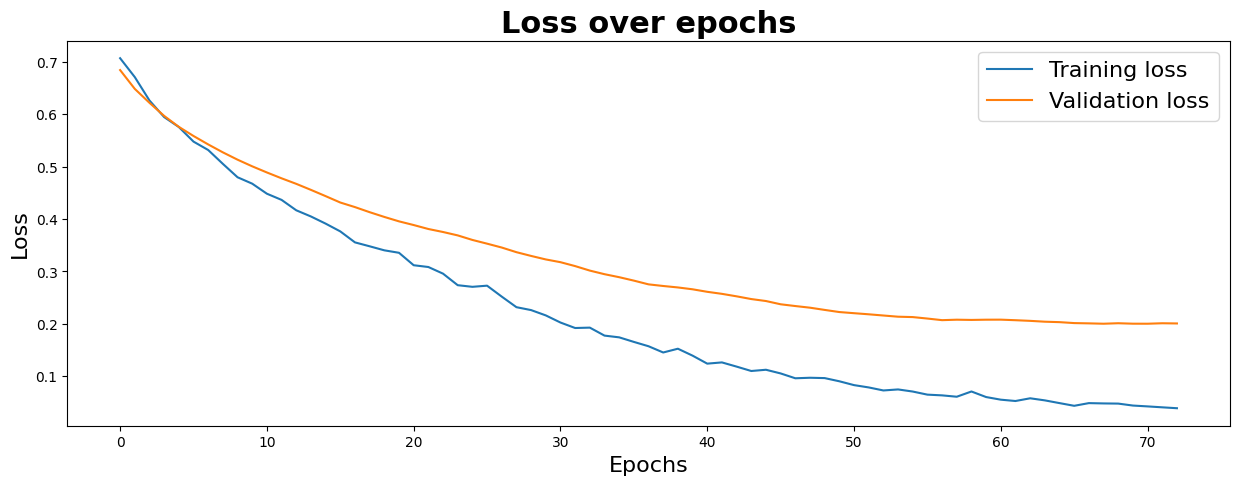

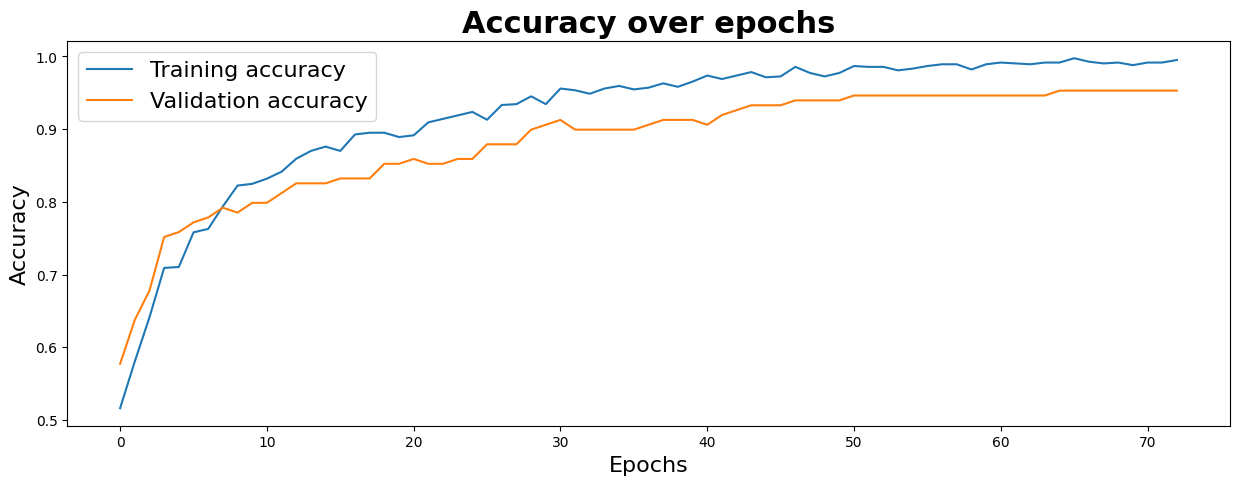

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_executed = early_stopping.stopped_epoch + 1
if epochs_executed != 1:
    rg = epochs_executed
else:
    rg = epochs    
plt.figure(figsize=(15,5))
plt.plot(range(rg), loss)
plt.plot(range(rg), val_loss)
plt.title('Loss over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(['Training loss', 'Validation loss'], fontsize=16)
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(15,5))
plt.plot(range(rg), acc)
plt.plot(range(rg), val_acc)
plt.title('Accuracy over epochs', weight='bold', fontsize=22)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=16)
plt.show()

Evaluating the model on the test set, calculating the confusion matrix, the f1-score, the recall and the accuracy

8/8 [==============================] - 4s 363ms/step


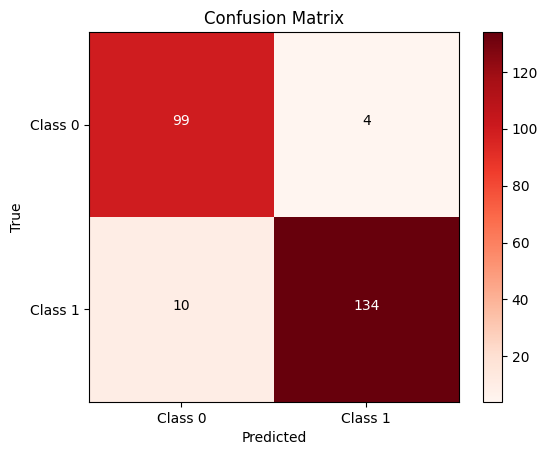

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       103
           1       0.97      0.93      0.95       144

    accuracy                           0.94       247
   macro avg       0.94      0.95      0.94       247
weighted avg       0.94      0.94      0.94       247



In [ ]:
test_loss, test_accuracy = model.evaluate(test_paths, test_labels)

predictions = model.predict(test_paths)

# Convert the predicted probabilities to class labels (0 or 1 in this case)
y_pred = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Class 0', 'Class 1'])
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
# Add text annotations within each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()

#Printing the accuracy, the f1-score and the recall for each class
predicted_probabilities = predictions.flatten()
predicted_labels = (predicted_probabilities >= 0.5).astype(int)

report = classification_report(test_labels, predicted_labels)
print(report)

In [ ]:
model.save("Notebook\LSTM")

INFO:tensorflow:Assets written to: Notebook\LSTM\assets


INFO:tensorflow:Assets written to: Notebook\LSTM\assets
